# Behind the Medals, there is ... <span style="color: red">HARDWORK</span> !


*Hamza El Bouatmani*  - March 2019

----



# Introduction
Although registered two years ago, I just started using the platform a couple of months ago, and was curious about how to become a Kaggle Expert or Master, so I decided to use the Kaggle Meta Dataset to dig into and examine some statistics related to Top Kernels and Top Kernel Authors.

I hope this Kernel will be useful.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


from IPython.display import display

import os
input_data = os.listdir("../input")
#print('Files: ', input_data)

# 1. Some Filtering <a id="1" />


In order to get the purest insights, we must take some time to clean the data we'll be working with. 
Not all Kernels in the dataset are relevant to us. We filter the kernels as follows:
- **Exclude Kernels with no UrlSlug**
- **Exclude Kernels whose authors are members of the Kaggle Team (we're interested in normal users and how they get medals)**
- **Exclude Kernels which are solutions to exercises (from Kaggle Learn section)**
- **Exclude Kernels where CreationDate & MadePublicDate are BOTH NULL ( we don't have any idea when they were created, maybe it's a Data Collection problem )**

In [2]:
kernels_df = pd.read_csv('../input/Kernels.csv')
users_df = pd.read_csv('../input/Users.csv')

init_nbr_kernels = len(kernels_df)
#print('Number of Kernels Before Filtering: ', init_nbr_kernels)
#print('Filtering ... ')

# Parse Date Columns
kernels_df['MadePublicDate'] = pd.to_datetime(kernels_df['MadePublicDate'])
kernels_df['CreationDate'] = pd.to_datetime(kernels_df['CreationDate'])
kernels_df['MedalAwardDate'] = pd.to_datetime(kernels_df['MedalAwardDate'])

# Exclude Kernels without Url Slug ( just two for at the time of writing )
kernels_df = kernels_df[~kernels_df['CurrentUrlSlug'].isnull()]

#Extract Kernels of the Kaggle Team
kaggle_team_users = users_df[users_df['PerformanceTier'] == 5]
kaggle_team_kernels = kernels_df[kernels_df['AuthorUserId'].isin(kaggle_team_users['Id'])]

# Exclude Kernels from the Kaggle Team
normal_user_kernels = kernels_df[~kernels_df['AuthorUserId'].isin(kaggle_team_users['Id'])]

# Exclude Exercise Kernels which are Forked (most if not all are just forks of exercises to learn a topic from the section Kaggle Learn, they're not relevant to us)
normal_user_kernels = normal_user_kernels[ ~((normal_user_kernels['CurrentUrlSlug'].str.contains('exercise')) & (~normal_user_kernels['ForkParentKernelVersionId'].isnull()) ) ]
assert len(normal_user_kernels[ (~normal_user_kernels['ForkParentKernelVersionId'].isnull()) & (normal_user_kernels['CurrentUrlSlug'].str.contains('exercise'))]) == 0


# Rows that have MadePublicDate NULL and CreationDate NOT NULL: we replace the NULL in MadePublicDate with the value of CreationDate
for i, r in normal_user_kernels.iterrows():
    if pd.isnull(r['MadePublicDate']) and not pd.isnull(r['CreationDate']):
        normal_user_kernels.at[i, 'MadePublicDate'] = r['CreationDate']
normal_user_kernels[(~normal_user_kernels['CreationDate'].isnull()) & (normal_user_kernels['MadePublicDate'].isnull())]

# Drop all other rows which have both dates NULL ( ~ 190 at time of writing )
normal_user_kernels = normal_user_kernels.drop(normal_user_kernels[normal_user_kernels['MadePublicDate'].isnull()].index)

# Join Kernels with Authors ( to have the author name on the same row to make things easy)
normal_user_kernels = normal_user_kernels.join(users_df.set_index('Id'), on='AuthorUserId')

# Replace NaN in 'Medal' with Zero
normal_user_kernels['Medal'] = normal_user_kernels['Medal'].fillna(0)

oldest_date = normal_user_kernels['MadePublicDate'].min()
newest_date = normal_user_kernels['MadePublicDate'].max()
range_dates_str = f"{oldest_date.strftime('%b %Y')} ~ {newest_date.strftime('%b %Y')}"

after_nbr_kernels = len(normal_user_kernels)
print('Number of Kernels after Filtering (', range_dates_str , '): ', after_nbr_kernels, f'({init_nbr_kernels - after_nbr_kernels} Kernels filtered)')

Number of Kernels after Filtering ( Mar 2015 ~ Feb 2019 ):  206962 (17317 Kernels filtered)


# 2. Medals are *<span style="color: #dca917">RARE</span>* ! <a id="2" />

Most of us, beginners in Kaggle, might look at the Top Kernels and Top authors and think that getting Medals is easy. However, a quick look into the Meta Kaggle data shows that Kernels awarded with Medals are ***extremely RARE*** compared to the number of kernels without medals.

**(You can hover to see the actual number values)**

In [3]:
# Pie Chats for Total Number of Kernels

PLOT_BG_COLOR = '#f1f1f1'

kernel_colors = ['#FF9999', '#66B3FF'] # ['awarded', 'not awarded']
medal_colors  = ['#ffd448', '#e9e9e9', '#f0ba7c' ] # ['Gold', 'Silver', 'Bronze']

medal_kernels = normal_user_kernels[normal_user_kernels['Medal'] > 0]

# First Pie Chart: Awarded vs Not Awarded Kernels
vals = []
vals.append(len(medal_kernels))
vals.append(len(normal_user_kernels[normal_user_kernels['Medal'] == 0]))
chart1 = {
            'type': 'pie',
            'title': 'Awarded vs Not Awarded',
            'titlefont': {'size': 16},
            'labels': ['Kernels Awarded', 'Kernels Not Awarded'],
            'values': vals,
            'hoverinfo': 'label+value',
            'textinfo': 'percent',
            'textposition': 'inside',
            'textfont': {'size': 12},
            'marker': {'colors': kernel_colors, 'line': {'color': 'white', 'width': 2,}},
            'domain': {'x': [0, 0.4], 'y': [0, 1]}
        }

# Second Pie Chart: Gold, Silver & Bronze Kernels
vals = []
vals.append(len(medal_kernels[medal_kernels['Medal'] == 1]))
vals.append(len(medal_kernels[medal_kernels['Medal'] == 2]))
vals.append(len(medal_kernels[medal_kernels['Medal'] == 3]))



chart2 = {
            'type': 'pie',
            'title': 'Gold, Silver & Bronze',
            'titlefont': {'size': 16},
            'showlegend': False,
            'labels': ['Gold', 'Silver', 'Bronze'],
            'values': vals,
            'hoverinfo': 'label+value',
            'textinfo': 'percent+label',
            'textfont': {'size': 12},
            'marker': {'colors': medal_colors, 'line': {'color': 'white', 'width': .5,}},
            'domain': {'x': [0.6, 1], 'y': [0,1]}
        }

fig = {
    'data': [ chart1, chart2 ],
    'layout': {
        'height': 500,
        'title': {
            'text': f'Total number of Public Kernels ({range_dates_str})',
            'font': {'size': 18}
        }, 'legend': {
            'orientation': 'h'
        }
    }
}

iplot(fig)

In [4]:
years = list(normal_user_kernels.MadePublicDate.dt.year.unique())
years.remove(2019) # Remove this year because it has just started
years.sort()
nbr_all_vals = []
nbr_awarded_vals = []
nbr_not_awarded_vals = []
nbr_gold_vals = []
nbr_silver_vals = []
nbr_bronze_vals = []

for y in years:
    if not np.isnan(y):
        years_kernels = normal_user_kernels[normal_user_kernels['MadePublicDate'].dt.year == y]
        nbr_all_vals.append(len(years_kernels))
        golds = len(years_kernels[years_kernels['Medal'] == 1])
        silvers = len(years_kernels[years_kernels['Medal'] == 2])
        bronzes = len(years_kernels[years_kernels['Medal'] == 3])
        nbr_awarded_vals.append(golds+silvers+bronzes)
        nbr_not_awarded_vals.append(nbr_all_vals[-1] - nbr_awarded_vals[-1])
        nbr_gold_vals.append(golds)
        nbr_silver_vals.append(silvers)
        nbr_bronze_vals.append(bronzes)
#print(years, nbr_all_vals, nbr_awarded_vals, nbr_gold_vals, nbr_silver_vals, nbr_bronze_vals)

In [5]:
# Bar Chart for Number of Kernels per year

fig = { 'data': [
        {   'type': 'bar',
            'name': 'Kernels w/o Awards',
            'x': years,
            'y': nbr_not_awarded_vals,
            'marker': {'color': kernel_colors[1] },
            'xaxis': 'x1',
            'yaxis': 'y1'
        },
        {   'type': 'bar',
            'name': 'Awarded Kernels',
            'x': years,
            'y': nbr_awarded_vals,
            'marker': {'color': kernel_colors[0] },
            #'line': {'color': '#ffd448' },
            'xaxis': 'x1',
            'yaxis': 'y1'
        }
], 'layout': {
        'plot_bgcolor': PLOT_BG_COLOR,
        'height': 600,
        'title': 'Change of Number of Kernels per year',
        'legend': {'orientation': 'h'},
        'xaxis': {'dtick': 1},
        'yaxis': {'dtick': 5000, 'title': 'Number of Kernels'}
    }}
iplot(fig)

In [6]:
# Bar & Line Chart for Awarded Kernels per Year by Medal

fig = { 'data': [
        {
            'type': 'bar',
            'name': 'Gold',
            'x': years,
            'y': nbr_gold_vals,
            'marker': {'color': medal_colors[0]},
        },
        {
            'type': 'bar',
            'name': 'Silver',
            'x': years,
            'y': nbr_silver_vals,
            'marker': {'color': medal_colors[1]},
        },
        {
            'type': 'bar',
            'name': 'Bronze',
            'x': years,
            'y': nbr_bronze_vals,
            'marker': {'color': medal_colors[2]},
        },
        {   'type': 'scatter',
            'name': 'Number of Awarded Kernels',
            'x': years,
            'y': nbr_awarded_vals,
            'line': {'color': kernel_colors[0] },
        },
    ], 'layout': {
        'title': 'Change of Number of Awarded Kernel per year',
        'legend': {'orientation': 'h'},
        'height': 600,
        'plot_bgcolor': PLOT_BG_COLOR,
        'xaxis': {'dtick': 1},
        'yaxis': {'dtick': 250, 'title': 'Number of Kernels'}
        
    }
}
iplot(fig)

### **<span style="color: red">Observation</span>**: Although the number of Kernels not awarded ***is much greater*** than the number of Kernels awarded, we can note a ***steady increase*** in the number of Awarded Kernels each year

# 3. Who publishes Top Kernels ? <a id="3" />

Let's now have a quick look at some of the Top Authors in Kaggle

In [7]:
nbr_medals_per_author = pd.crosstab( [normal_user_kernels['AuthorUserId'], normal_user_kernels['DisplayName']], normal_user_kernels['Medal'])
nbr_medals_per_author = nbr_medals_per_author.rename(columns={0: 'NotAwarded', 1.0: 'Gold', 2.0: 'Silver', 3.0: 'Bronze'})
nbr_medals_per_author['Awarded'] = nbr_medals_per_author['Gold'] + nbr_medals_per_author['Silver'] + nbr_medals_per_author['Bronze']
nbr_medals_per_author = nbr_medals_per_author.sort_values(by='Awarded', ascending=False)
nbr_medals_per_author = nbr_medals_per_author.reset_index(level=1) # Make DisplayName a column

n = 30
top = nbr_medals_per_author[:n]


fig = {
    'data': [
        {
            'type': 'bar',
            'y': top['Bronze'].values,
            'x': top['DisplayName'].values,
            'name': 'Bronze',
            'marker': {'color': medal_colors[2]}
        }, {
            'type': 'bar',
            'y': top['Silver'].values,
            'x': top['DisplayName'].values,
            'name': 'Silver',
            'marker': {'color': medal_colors[1]}
        }, {
            'type': 'bar',
            'y': top['Gold'].values,
            'x': top['DisplayName'].values,
            'name': 'Gold',
            'marker': {'color': medal_colors[0]}
        }
    ], 'layout': {
        'title': f'Top {n} Kernel Authors ({range_dates_str})',
        'barmode': 'stack',
        'yaxis': {'title': 'Number of Awarded Kernels'},
        'legend': {'x': 0.92, 'y': 1},
        'margin': {'r': 0},
        #'plot_bgcolor': PLOT_BG_COLOR,
    }
}

iplot(fig)

### **<span style="color: red">Impressive !</span> **   [Mr Ashish Patel](https://www.kaggle.com/ashishpatel26) comes in top with 72 Awarded Kernels, but there is a lot of competition between the Top 4.

*(Note: There are many other great Kernel Authors not figuring in the list. You can fork this kernel and play with the n parameter in the code, to get the Top n Authors in terms of number of awarded Kernels)*

# 4. It's not always **<span style="color: #dca917">Gold</span>** ! <a id="4" />

After seeing the last graph, one might think that those authors are ***Super Humans*** ! However, the **DATA** says that it's the product of **<span style="color: red">HARDWORK</span>** and **<span style="color: red">PASSION</span>**!

The following graph illustrates the proportion of Awarded & Not Awarded Kernels for each of the Top Authors :

In [8]:

fig = {
    'data': [
        {
            'type': 'bar',
            'y': top['NotAwarded'].values,
            'x': top['DisplayName'].values,
            'name': 'Not Awarded Kernels',
            'marker': {'color': kernel_colors[1]}
        },{
            'type': 'bar',
            'y': top['Awarded'].values,
            'x': top['DisplayName'].values,
            'name': 'Awarded Kernels',
            'marker': {'color': kernel_colors[0]}
        }
    ], 'layout': {
        'title': f'Top {n} Kernel Authors ({range_dates_str})',
        'barmode': 'stack',
        'yaxis': {'title': 'Number of Kernels'},
        'legend': {'x': 0.78, 'y': 1},
        'plot_bgcolor': PLOT_BG_COLOR,
        'margin': {'r': 0}
    }
}

iplot(fig)

### **<span style="color: red">Observation</span>**: Many Top Authors wrote *several non-awarded Kernels*. This shows that their success is the product of *<span style="color: red">HARDWORK</span>* ! It's not always *<span style="color: #dca917">GOLD</span>* !

*(Note: It is possible that an author deletes some of his previously published Kernels. The graph is based on the Meta Kaggle dataset which only shows currently public Kernels )*

# 5. You <span style="color: red">CAN</span> do it too ! <a id="5" />

### One might also think that these Top Authors are the ones who publish the most in Kaggle. However, the **DATA** says something else !

The following graph shows the how many kernels were published by each Author Category (Preformance Tier):

In [9]:
nbr_awarded_kernels_per_tier = medal_kernels['PerformanceTier'].value_counts()
nbr_awarded_kernels_per_tier = nbr_awarded_kernels_per_tier.sort_index()
#nbr_awarded_kernels_per_tier

tier_colors = ['#5AC995', '#00BBFF', '#976591', '#F96517', '#DCA917']

fig = {
    'data': [{
        'type': 'pie',
        'labels': ['Novices', 'Contributors', 'Experts', 'Masters', 'Grandmasters'],
        'values': nbr_awarded_kernels_per_tier,
        'hole': .3,
        'textinfo': 'percent+label',
        'marker': {'colors': tier_colors}
    }],
    'layout': {
        'title': f'Number of Awarded Kernels by Author Tier',
        'showlegend': False
    }
}
iplot(fig)

### **<span style="color: red">Observation</span>**: <span style="color: #976591"> Experts</span> produce the most number of Kernels ( probably because they want to become Masters). Then followed by <span style="color: #00BBFF">Contributors</span> ! After them come <span style="color: #F96517">Masters</span> and then <span style="color: #5AC995">Novices</span> ! Lastly we have <span style="color: #DCA917">Grandmasters</span> producing ~7.8% of the Awarded Kernels (probably because there only according to the [first chart](#2) only 8.5% of the authors have reached that level)

# 6. When did the Top Authors start publishing ?<a id="6" />

Another interesting thing to examine, is when did the Top authors start publishing their first Kernels. In other words, how much time did it take them to reach this level.

In [10]:
# Date of first kernel
n = 50
top = nbr_medals_per_author.head(n)
oldest_kernel_dates = []
for userid in top.index:
    oldest_kernel_date = normal_user_kernels[normal_user_kernels['AuthorUserId'] == userid]['MadePublicDate'].min()
    oldest_kernel_dates.append(oldest_kernel_date)
oldest_kernel_dates = pd.Series(oldest_kernel_dates, index=top.index).sort_values()

# Date of first kernel

#fig = ff.create_distplot(s, [f'Top {n} authors'])


fig= {
    'data': [
        {
            'type': 'histogram',
            #'bin_size': .4,
            'marker': {"color": 'red', 'line': {'color': 'white', 'width': 2}}, 
            'x': oldest_kernel_dates,
            "opacity": 0.5, 
        }
    ],
    'layout': {
        'title': f'Dates of First Published Kernel (top {n} Authors)',
        'xaxis': {'title': 'Date of First Published Kernel'},
        'yaxis': {'title': 'Number of Authors'}
    }
}

iplot(fig)

### **<span style="color: red">Observation</span>**:  **More than 50%** of the Top Authors started before January 2017 ( **more than one year ago** )

(*Note: This only shows how much experience the top authors have on Kaggle, we're not taking into account their Data Science experience prior to Kaggle*)

# 7. Tags in Top Kernels <a id="7" />

Lastly, we examine the most used tags in the awarded Kernels.

<Figure size 432x288 with 0 Axes>

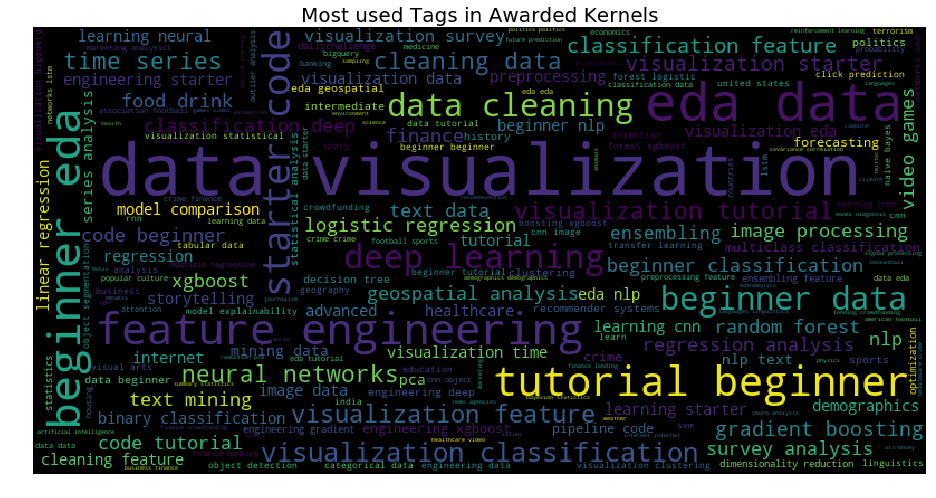

In [11]:
tags_df = pd.read_csv('../input/Tags.csv')
normal_user_kernel_tags = pd.read_csv('../input/KernelTags.csv')
normal_user_kernel_tags = normal_user_kernel_tags[normal_user_kernel_tags['KernelId'].isin(normal_user_kernels['Id'])]
medal_kernels_tag_ids = normal_user_kernel_tags[normal_user_kernel_tags['KernelId'].isin(medal_kernels['Id'])]['TagId']
tags_df = tags_df.set_index('Id')
tags_dic = tags_df[['Slug', 'Name']].to_dict('index')
slugs = []
for tid in medal_kernels_tag_ids:
    slugs.append(tags_dic[tid]['Slug'])

wc=WordCloud(width=800, height=400).generate(' '.join(slugs))
plt.clf()
plt.figure( figsize=(16,9) )
plt.title('Most used Tags in Awarded Kernels', fontsize=20)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [12]:
# Bar chart for Top used Tags in Awarded Kernels

n = 30
slug_counts = pd.Series(slugs).value_counts().head(n)

fig = {
    'data': [
        {
            'type': 'bar',
            #'orientation': 'h',
            'y': slug_counts,
            'x': slug_counts.index,
            'marker': {'color': slug_counts, 'colorscale': 'Viridis', 'showscale': True}
        }
    ], 'layout': {
        'title': f'Top {n} most used Tags in Awarded Kernels',
        'yaxis': {'title': 'Number of times used'}
    }
}
iplot(fig)

### **<span style="color: red">Observation</span>**:  It seems that top Kernels are directed towards **Beginners**, and are centered around **Exploratory Data Analysis** and **Visualization**

# 8. Python vs R <a id="8" />

In [13]:
normal_user_kernel_versions = pd.read_csv('../input/KernelVersions.csv')
normal_user_kernel_versions = normal_user_kernel_versions[normal_user_kernel_versions['KernelId'].isin(normal_user_kernels['Id'])]
normal_user_kernel_versions = normal_user_kernel_versions.drop(normal_user_kernel_versions[normal_user_kernel_versions['VersionNumber'].isnull()].index, axis=0)

kernel_languages_dic = pd.read_csv('../input/KernelLanguages.csv')
kernel_languages_dic = kernel_languages_dic.set_index('Id')
kernel_languages_dic = kernel_languages_dic.drop(['Name', 'IsNotebook'], axis=1)
kernel_languages_dic = kernel_languages_dic.to_dict('index')
#kernel_languages_dic

normal_user_kernel_versions = normal_user_kernel_versions.set_index('Id')

#
normal_user_kernels['KernelLanguage'] = ''
for i,k in normal_user_kernels.iterrows():
    kv_id = k['CurrentKernelVersionId']
    if not np.isnan(kv_id):
        kv_id = int(kv_id)
        if kv_id in normal_user_kernel_versions.index:
            x = normal_user_kernel_versions.loc[kv_id]
            lan_id = x['KernelLanguageId']
            #print(lan_id)
            if lan_id in kernel_languages_dic.keys():
                language = kernel_languages_dic[lan_id]['DisplayName']
                #print(language)
                normal_user_kernels.at[i, 'KernelLanguage'] = language
                
medal_kernels = normal_user_kernels[normal_user_kernels['Medal'] > 0]
medal_kernels_by_language = medal_kernels.groupby('KernelLanguage')['Id'].count()
# Some of them are neither Python nor R probably problem of data collection because in KernelLanguages table there is only R and Python

fig = {
    'data': [
        {
            'type': 'pie',
            'values': [medal_kernels_by_language['Python'], medal_kernels_by_language['R']],
            'labels': ['Python', 'R'],
            'marker': {'colors': ['#FFD548','#2167BA']},
            'textinfo': 'percent+label',
            'hole': .3,
            'showlegend': False
        }
    ],
    'layout': {
        'title': 'Awarded Kernels by Language'
    }
    
}

iplot(fig)

### **<span style="color: red">Observation</span>**:  Python is largely used and preferred in Awarded Kernels.

# 9. Time for some Correlation ! <a id="9" />

In [14]:
nbr_medals_per_author['NbrPythonKernels'] = 0
nbr_medals_per_author['NbrRKernels'] = 0

for userid in nbr_medals_per_author.index:
    kernel_languages = normal_user_kernels[normal_user_kernels['AuthorUserId'] == userid]['KernelLanguage']
    kernel_languages = kernel_languages.value_counts()
    if 'Python' in kernel_languages.index:
        nbr_medals_per_author.at[userid, 'NbrPythonKernels'] = kernel_languages['Python']
    if 'R' in kernel_languages.index:
        nbr_medals_per_author.at[userid, 'NbrRKernels'] = kernel_languages['R']
    #print(kernel_languages.index)

# Add MonthsOfExperience Field
oldest_kernel_dates = []
for userid in nbr_medals_per_author.index:
    oldest_kernel_date = normal_user_kernels[normal_user_kernels['AuthorUserId'] == userid]['MadePublicDate'].min()
    oldest_kernel_dates.append(oldest_kernel_date)

oldest_kernel_dates = pd.Series(oldest_kernel_dates, index=nbr_medals_per_author.index)
oldest_kernel_dates = ((pd.Timestamp.now() - oldest_kernel_dates)/ np.timedelta64(1,'M')).astype('int')
nbr_medals_per_author['MonthsOfExperience'] = oldest_kernel_dates
#nbr_medals_per_author.head()

# Add NumberPublishedKernels Field
nbr_medals_per_author['NbrPublishedKernels'] = nbr_medals_per_author['Awarded'] + nbr_medals_per_author['NotAwarded']
nbr_medals_per_author.head()

top_tags = tags_df[tags_df['Slug'].isin(slug_counts.index)].index
#top_tags

nbr_medals_per_author['NbrTopTagsUsed'] = 0
for userid in nbr_medals_per_author.index:
    kernel_ids = normal_user_kernels[normal_user_kernels['AuthorUserId'] == userid]['Id']
    tag_ids = normal_user_kernel_tags[normal_user_kernel_tags['KernelId'].isin(kernel_ids)]['TagId']
    relevant_tag_ids = [tid for tid in tag_ids if tid in top_tags]
    nbr_medals_per_author.at[userid, 'NbrTopTagsUsed'] = len(relevant_tag_ids)
#nbr_medals_per_author['NbrTopTagsUsed']



df = nbr_medals_per_author.drop(['Gold', 'Silver', 'Bronze', 'NotAwarded', 'DisplayName'], axis=1)
df = df.rename(columns={'Awarded': 'NbrAwardedKernels'})
corr = df.corr()
fig = {
    'data': [
        {
            'type': 'heatmap',
            'z': corr,
            'x': df.columns,
            'y': df.columns,
            'colorscale': 'Reds'
        }
    ],
    'layout': {
        'title': 'Correlation Heatmap',
        'margin':{
            'l': 140
        }
    }
}

iplot(fig)

### **<span style="color: red">Observation</span>**:  We can see that Number of Published Kernels, Python Kernels & Number of Top Tags Used are positively correlated with Number of Awarded Kernels

# Conclusions:

* There are of course many criteria other than the ones mentioned for a Kernel to be successful, for example: It must be written and formatted nicely, must add value to the reader and be interesting.

* Most Awarded Kernels are Tutorials and Visualizations

* Most Awarded Kernels are written in Python

* In Data Science as in Every Discipline, Success comes with two principal ingredients: **<span style="color: red">PASSION & HARDWORK</span>**

## References:

* [Kaggle Progression System](https://www.kaggle.com/progression) (Page)
* [Kaggle Trends](https://www.kaggle.com/gaborfodor/kaggle-trends) (Kernel)
* [How to get upvotes in Kaggle](https://www.kaggle.com/aleksandradeis/how-to-get-upvotes-for-a-kernel-on-kaggle) (Kernel)